In [ ]:
pip install statsmodels pandas numpy

In [ ]:
!pip install nbconvert

# Hypotheses testing for QoS Forecasting models

We tested the null hypotheses through a statistical comparison of performance values (RMSE, MAE, MAPE, training time) across the three treatments (BI-GRU, LSTM, and ARIMA), all applied to the same experimental object (SAlert cloud service).

## Load data from excel

Loading the data from an Excel file into a pandas DataFrame.


In [ ]:
import pandas as pd

#Upload the file and remove the comment from the uploaded file

#df = pd.read_excel('FreeMemory.xlsx')
#file_var = 'QoS1'
#df = pd.read_excel('UsedMemory.xlsx')
#file_var = 'QoS2'
#df = pd.read_excel('FreeDisk.xlsx')
#file_var = 'QoS3'
#df = pd.read_excel('UsedDisk.xlsx')
#file_var = 'QoS4'
#df = pd.read_excel('Diskread.xlsx')
#file_var = 'QoS5'
df = pd.read_excel('DiskWrite.xlsx')
file_var = 'QoS6'
#df = pd.read_excel('NetBytesIn.xlsx')
#file_var = 'QoS7'
#df = pd.read_excel('NetBytesOut.xlsx')
#file_var = 'QoS8'
#df = pd.read_excel('NetPacketsIn.xlsx')
#file_var = 'QoS9'
#df = pd.read_excel('NetPacketsOut.xlsx')
#file_var = 'QoS10'
#df = pd.read_excel('Rxpackets.xlsx')
#file_var = 'QoS11'
#df = pd.read_excel('Txpackets.xlsx')
#file_var = 'QoS12'
#df = pd.read_excel('CPUpercent.xlsx')
#file_var = 'QoS13'
#df = pd.read_excel('MemoryUsedpercent.xlsx')
#file_var = 'QoS14'
#df = pd.read_excel('DiskUsedpercent.xlsx')
#file_var = 'QoS15'
#df = pd.read_excel('Uptime.xlsx')
#file_var = 'QoS16'


## Data preparation

Ensure that the data is in the correct format. This may include identifying dependent and independent variables, check for missing values, and ensure independent variables are treated as categorical.


In [ ]:
dependent_vars = ['RMSE', 'MAE', 'MAPE', 'TRAINTIME' ]
independent_vars = ['Model', 'Fold']

# Check for missing values in relevant columns
print("Missing values before handling:")
print(df[dependent_vars + independent_vars].isnull().sum())

# Drop rows with missing values in the relevant columns
df_cleaned = df.dropna(subset=dependent_vars + independent_vars)

# Ensure independent variables are treated as categorical
df_cleaned[independent_vars] = df_cleaned[independent_vars].astype('category')

print("\nMissing values after handling:")
print(df_cleaned[dependent_vars + independent_vars].isnull().sum())

print("\nData types of independent variables after handling:")
print(df_cleaned[independent_vars].dtypes)


Missing values before handling:
RMSE         0
MAE          0
MAPE         0
TRAINTIME    0
Model        0
Fold         0
dtype: int64

Missing values after handling:
RMSE         0
MAE          0
MAPE         0
TRAINTIME    0
Model        0
Fold         0
dtype: int64

Data types of independent variables after handling:
Model    category
Fold     category
dtype: object


##Visualize data
Scatterplot of the relationship between RMSE, MAE, MAPE, TRAINTIME.

Create a box plot for each dependent variable against the independent variable 'Model'.

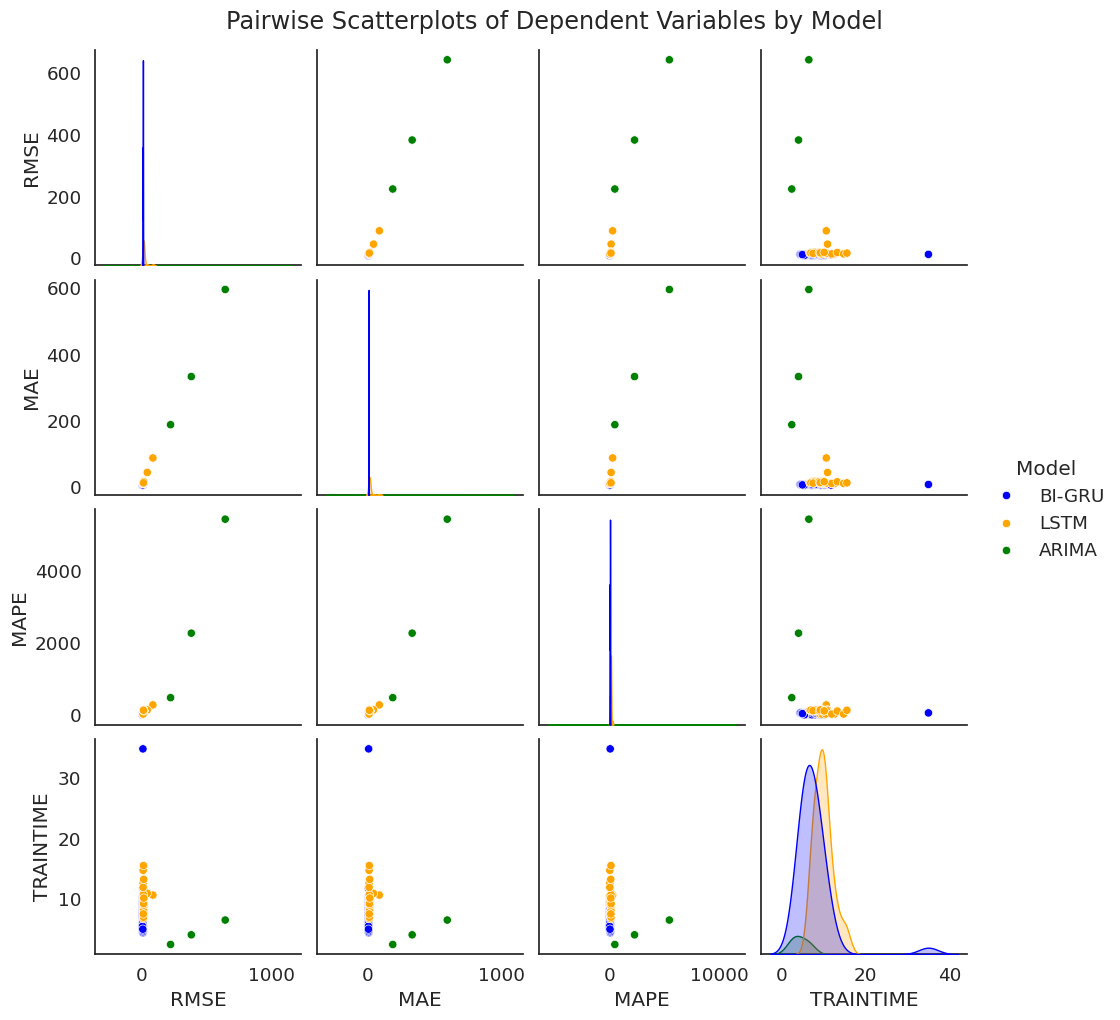

In [ ]:
#Scatterplot of the relationship between RMSE, MAE, MAPE, TRAINTIME
import matplotlib.pyplot as plt
import seaborn as sns

#dependent_vars = ['RMSE', 'MAE', 'MAPE', 'TRAINTIME']
#independent_var =['Model', 'Fold'] # This was causing the error

# Define a custom color palette (same as used for box plots)
model_colors = {
    'BI-GRU': 'blue',
    'LSTM': 'orange',
    'ARIMA': 'green'
}

# Define the desired order for the hue categories
model_order = ['BI-GRU', 'LSTM', 'ARIMA']

# Create a scatter matrix (pairwise scatterplots) of the dependent variables
# Use df_cleaned as it has handled missing values and converted types
# Add hue and palette to color points by 'Model' and specify the order
sns.pairplot(df_cleaned[dependent_vars + ['Model']], hue='Model', palette=model_colors, hue_order=model_order)


plt.suptitle('Pairwise Scatterplots of Dependent Variables by Model', y=1.02) # Add a title
plt.show()

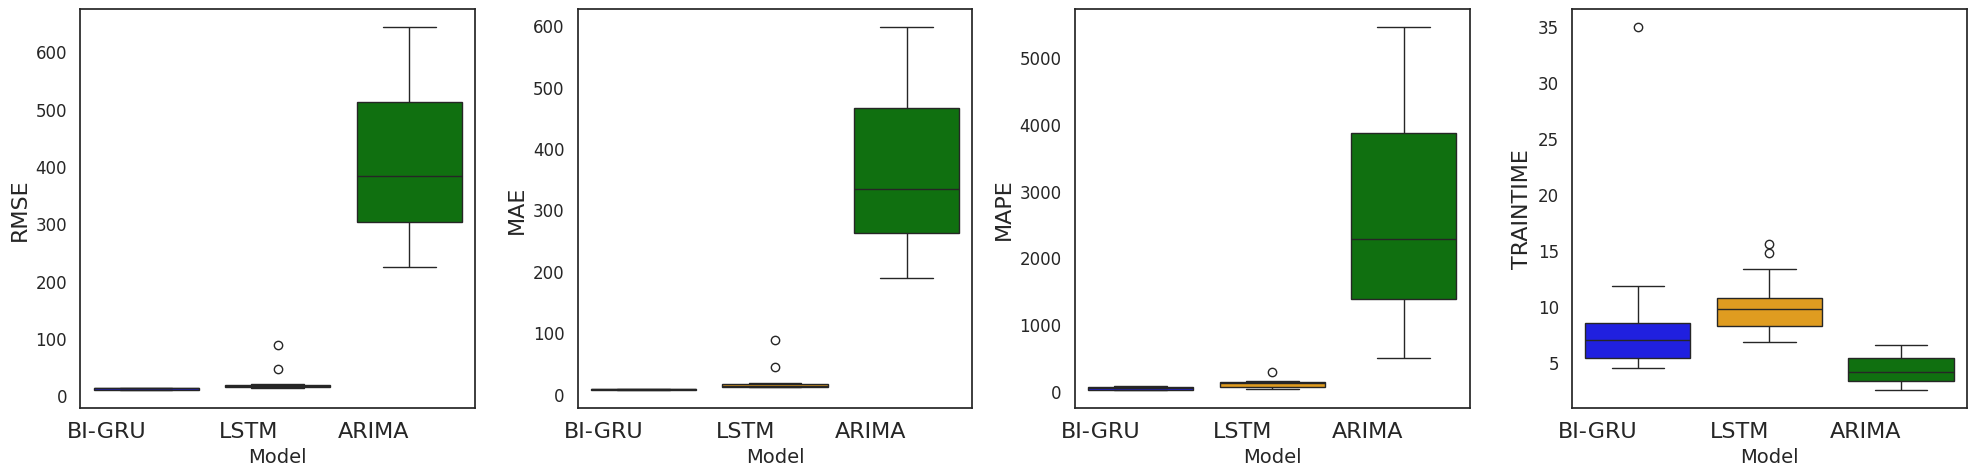

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

dependent_vars = ['RMSE', 'MAE', 'MAPE', 'TRAINTIME']
independent_var = 'Model'

# Define a custom color palette
model_colors = {
    'BI-GRU': 'blue',
    'LSTM': 'orange',
    'ARIMA': 'green'
}

# Define the desired order for the x-axis categories
model_order = ['BI-GRU', 'LSTM', 'ARIMA']


# Create a figure with a 1x4 grid of subplots and adjust figure size
plt.figure(figsize=(20, 5)) # Increased width to accommodate 4 plots in a row

for i, dep_var in enumerate(dependent_vars):
    # Create a box plot for each dependent variable against the independent variable 'Model'
    plt.subplot(1, 4, i + 1) # Changed subplot grid to 1 row and 4 columns
    # Use the custom palette and specify the order, and set hue and legend to suppress warning
    sns.boxplot(x=independent_var, y=dep_var, data=df_cleaned, palette=model_colors, order=model_order, hue=independent_var, legend=False)
    #plt.title(f'{dep_var} by {independent_var}', fontsize=12) # Increased title font size

    plt.xlabel(independent_var, fontsize=14) # Increased x-axis label font size
    plt.ylabel(dep_var, fontsize=16) # Increased y-axis label font size
    plt.xticks(rotation=0, ha='right', fontsize=16) # Rotate and increase x-axis tick font size
    plt.yticks(fontsize=12) # Increase y-axis tick font size


plt.tight_layout()

# Save the figure to a PDF file
plt.savefig(file_var +'_boxplot_metrics.pdf', bbox_inches='tight')

plt.show()

##Normality Test (Shapiro-Wilk)

In [ ]:
from scipy.stats import shapiro
import numpy as np

print("--- Normality Test (Shapiro-Wilk) ---")

# Group data by the independent variable 'Model'
# Corrected to group by 'Model' only for normality testing
grouped_data = df_cleaned.groupby(independent_vars[0])


# Use the original dependent variables
for dep_var in dependent_vars:
    print(f"\nAnalyzing normality for '{dep_var}':")
    for group_name, group_data in grouped_data:
        # Check if sample size is sufficient for Shapiro-Wilk test (at least 3)
        if len(group_data[dep_var]) >= 3:
            # Perform Shapiro-Wilk test
            stat, p_value = shapiro(group_data[dep_var])

            print(f"  Group '{group_name}':")
            print(f"    Shapiro-Wilk Statistic: {stat:.4f}")
            print(f"    P-value: {p_value:.4f}")

            # Interpret the result
            alpha = 0.05
            if p_value < alpha:
                print(f"    Result: The assumption of normality is violated for '{dep_var}' in group '{group_name}' (p < {alpha}).")
            else:
                print(f"    Result: The assumption of normality is met for '{dep_var}' in group '{group_name}' (p >= {alpha}).")
        else:
            print(f"  Group '{group_name}':")
            print(f"    Sample size ({len(group_data[dep_var])}) is too small to perform Shapiro-Wilk test.")


print("\n--- End of Normality Test ---")

--- Normality Test (Shapiro-Wilk) ---

Analyzing normality for 'RMSE':
  Group 'ARIMA':
    Shapiro-Wilk Statistic: 0.9809
    P-value: 0.7351
    Result: The assumption of normality is met for 'RMSE' in group 'ARIMA' (p >= 0.05).
  Group 'BI-GRU':
    Shapiro-Wilk Statistic: 0.7631
    P-value: 0.0000
    Result: The assumption of normality is violated for 'RMSE' in group 'BI-GRU' (p < 0.05).
  Group 'LSTM':
    Shapiro-Wilk Statistic: 0.3887
    P-value: 0.0000
    Result: The assumption of normality is violated for 'RMSE' in group 'LSTM' (p < 0.05).

Analyzing normality for 'MAE':
  Group 'ARIMA':
    Shapiro-Wilk Statistic: 0.9731
    P-value: 0.6850
    Result: The assumption of normality is met for 'MAE' in group 'ARIMA' (p >= 0.05).
  Group 'BI-GRU':
    Shapiro-Wilk Statistic: 0.8791
    P-value: 0.0006
    Result: The assumption of normality is violated for 'MAE' in group 'BI-GRU' (p < 0.05).
  Group 'LSTM':
    Shapiro-Wilk Statistic: 0.3985
    P-value: 0.0000
    Result: Th

/tmp/ipython-input-940823296.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_cleaned.groupby(independent_vars[0])


##Homogeneity of variances Test (Brown-Forsythe)

In [ ]:
from scipy.stats import levene
import numpy as np

print("--- Homogeneity of Variances Test (Brown-Forsythe) ---")

# Group data by the independent variable 'Model'
# Corrected to use independent_vars[0] to access 'Model' and added observed=False
groups = df_cleaned.groupby(independent_vars[0], observed=False)

# Extract the data for each group for each dependent variable
grouped_data = {}
# Use the original dependent variables for grouping the data
for dep_var in dependent_vars:
    # Corrected to use independent_vars[0] for grouping in list comprehension and added observed=False
    grouped_data[dep_var] = [group_data[dep_var].values for name, group_data in df_cleaned.groupby(independent_vars[0], observed=False)]

# Perform Levene test with center='median' (Brown-Forsythe)
for dep_var in dependent_vars:
    print(f"\nAnalyzing homogeneity of variances for '{dep_var}':")
    # The levene function takes the groups as separate arguments
    stat, p_value = levene(*grouped_data[dep_var], center='median')

    print(f"  Levene Statistic (Brown-Forsythe): {stat:.4f}")
    print(f"  P-value: {p_value:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value < alpha:
        print(f"  Result: The assumption of homogeneity of variances is violated for '{dep_var}' (p < {alpha}).")
    else:
        print(f"  Result: The assumption of homogeneity of variances is met for '{dep_var}' (p >= {alpha}).")

print("\n--- End of Homogeneity of Variances Test ---")

--- Homogeneity of Variances Test (Brown-Forsythe) ---

Analyzing homogeneity of variances for 'RMSE':
  Levene Statistic (Brown-Forsythe): 46.8290
  P-value: 0.0000
  Result: The assumption of homogeneity of variances is violated for 'RMSE' (p < 0.05).

Analyzing homogeneity of variances for 'MAE':
  Levene Statistic (Brown-Forsythe): 43.7980
  P-value: 0.0000
  Result: The assumption of homogeneity of variances is violated for 'MAE' (p < 0.05).

Analyzing homogeneity of variances for 'MAPE':
  Levene Statistic (Brown-Forsythe): 51.5153
  P-value: 0.0000
  Result: The assumption of homogeneity of variances is violated for 'MAPE' (p < 0.05).

Analyzing homogeneity of variances for 'TRAINTIME':
  Levene Statistic (Brown-Forsythe): 0.3897
  P-value: 0.6787
  Result: The assumption of homogeneity of variances is met for 'TRAINTIME' (p >= 0.05).

--- End of Homogeneity of Variances Test ---


## Permutational Multivariate Analysis of Variance (PERMANOVA)

Since the assumption of normality for MANOVA was violated, a non-parametric alternative like PERMANOVA is more appropriate. PERMANOVA tests for differences between groups based on distance matrices and permutation.

In [ ]:
# Install scikit-bio if you haven't already
!pip install scikit-bio

In [ ]:
import numpy as np
import pandas as pd
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Define Y using your cleaned DataFrame and dependent variables
Y = df_cleaned[dependent_vars]

# assume Y is your DataFrame of dependent vars (rows aligned to samples)
# and euclidean_dist_matrix is your computed matrix (or None to recompute)
# if you want to recompute: set recompute=True
recompute = False

# Use your objects; if euclidean_dist_matrix not set or recompute True, recompute
try:
    D_orig = euclidean_dist_matrix if (not recompute) else None
except NameError:
    D_orig = None

if D_orig is None:
    print("Recomputing distance matrix from Y (recommended).")
    # Optionally scale columns here if needed: from sklearn.preprocessing import StandardScaler
    Y_scaled = StandardScaler().fit_transform(Y)
    D = pairwise_distances(Y_scaled, metric='euclidean') # Use Y_scaled here
else:
    D = np.asarray(D_orig)

print("Initial dtype:", D.dtype, "shape:", D.shape)
print("Is contiguous (C):", D.flags['C_CONTIGUOUS'], "F:", D.flags['F_CONTIGUOUS'])
print("Any NaNs:", np.isnan(D).any(), "Any infs:", np.isinf(D).any())

# Force float64, contiguous C array
D = np.array(D, dtype=np.float64, order='C')

# Strong symmetrize (averaging) and set diagonal exactly zero
D = (D + D.T) / 2.0
np.fill_diagonal(D, 0.0)

# Diagnostics after forced fixes
asym = np.max(np.abs(D - D.T))
print("After symmetrize: dtype:", D.dtype, "contiguous:", D.flags['C_CONTIGUOUS'])
print("Max asymmetry:", asym)
print("Diagonal (first 6):", D.diagonal()[:6])

# Prepare ids: ensure they are unique strings and same length
ids = [str(x) for x in Y.index.tolist()]
print("len(ids):", len(ids), "unique ids:", len(set(ids)) == len(ids))

# Final attempt to create DistanceMatrix
from skbio.stats.distance._base import DistanceMatrixError
try:
    dm = DistanceMatrix(D, ids=ids)
    print("DistanceMatrix created. shape:", dm.shape)
except DistanceMatrixError as e:
    print("DistanceMatrixError raised:", repr(e))
    # Additional diagnostics to return for debugging:
    print("Type of D:", type(D))
    print("D.dtype:", D.dtype)
    print("first 5x5 of D:\n", D[:5, :5])
    # show a small string of ids
    print("first 10 ids:", ids[:10])
    # show whether allclose with transpose using numpy default tolerance
    print("np.allclose(D, D.T):", np.allclose(D, D.T))
    # raise again so notebook shows full traceback if you prefer
    raise

Recomputing distance matrix from Y (recommended).
Initial dtype: float64 shape: (72, 72)
Is contiguous (C): True F: False
Any NaNs: False Any infs: False
After symmetrize: dtype: float64 contiguous: True
Max asymmetry: 0.0
Diagonal (first 6): [0. 0. 0. 0. 0. 0.]
len(ids): 72 unique ids: True
DistanceMatrix created. shape: (72, 72)


In [ ]:
# 1️⃣ Ensure df_cleaned index is string type
df_tmp = df_cleaned.copy()
df_tmp.index = df_tmp.index.map(str)

# 2️⃣ Make sure only the samples used in DistanceMatrix are selected
# dm.ids contains only the rows used to compute D (after dropping NaNs)
# Use intersection to safely align
common_ids = [i for i in dm.ids if i in df_tmp.index]

grouping_aligned = df_tmp.loc[common_ids, 'Model'].astype(str)

print("Number of samples in grouping_aligned:", len(grouping_aligned))
print("Group counts:\n", grouping_aligned.value_counts())

# 3️⃣ Run PERMANOVA
from skbio.stats.distance import permanova

permanova_results = permanova(distance_matrix=dm,
                              grouping=grouping_aligned,
                              permutations=999)

print("\nPERMANOVA Test Results:")
print(permanova_results)


# Interpretation tip:
# - The 'p-value' indicates whether the multivariate centroids differ significantly between groups.
# - A p-value < 0.05 (or chosen alpha) suggests a statistically significant difference.
# - The 'test statistic' (pseudo-F) shows the relative separation between group centroids.

print("\nGroup counts:")
print(grouping_aligned.value_counts())


Number of samples in grouping_aligned: 72
Group counts:
 Model
BI-GRU    39
LSTM      30
ARIMA      3
Name: count, dtype: int64

PERMANOVA Test Results:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      72
number of groups                  3
test statistic            49.954119
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

Group counts:
Model
BI-GRU    39
LSTM      30
ARIMA      3
Name: count, dtype: int64


##Pairwise PERMANOVA with Bonferroni correction

In [ ]:
import itertools
import pandas as pd
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests

# dm: your DistanceMatrix object
# grouping_aligned: aligned pandas Series with model labels

# Get unique groups
groups = grouping_aligned.unique()
pairs = list(itertools.combinations(groups, 2))  # all pairwise combinations

results = []

for g1, g2 in pairs:
    # Select samples belonging to the two groups
    mask = grouping_aligned.isin([g1, g2])
    sub_dm = dm.filter(ids=grouping_aligned[mask].index)
    sub_grouping = grouping_aligned[mask]

    # Run PERMANOVA on the pair
    res = permanova(distance_matrix=sub_dm, grouping=sub_grouping, permutations=999)
    results.append({
        'Group1': g1,
        'Group2': g2,
        'pseudo-F': res['test statistic'],
        'p-value': res['p-value']
    })

# Convert to DataFrame
df_pairwise = pd.DataFrame(results)

# Adjust p-values for multiple comparisons (Bonferroni)
df_pairwise['p-adj'] = multipletests(df_pairwise['p-value'], method='bonferroni')[1]

print("Pairwise PERMANOVA results:")
print(df_pairwise)


Pairwise PERMANOVA results:
   Group1 Group2   pseudo-F  p-value  p-adj
0  BI-GRU   LSTM   5.740259    0.004  0.012
1  BI-GRU  ARIMA  60.381642    0.001  0.003
2    LSTM  ARIMA  75.952552    0.001  0.003


##Visualization of multivariate separation and confidence ellipses

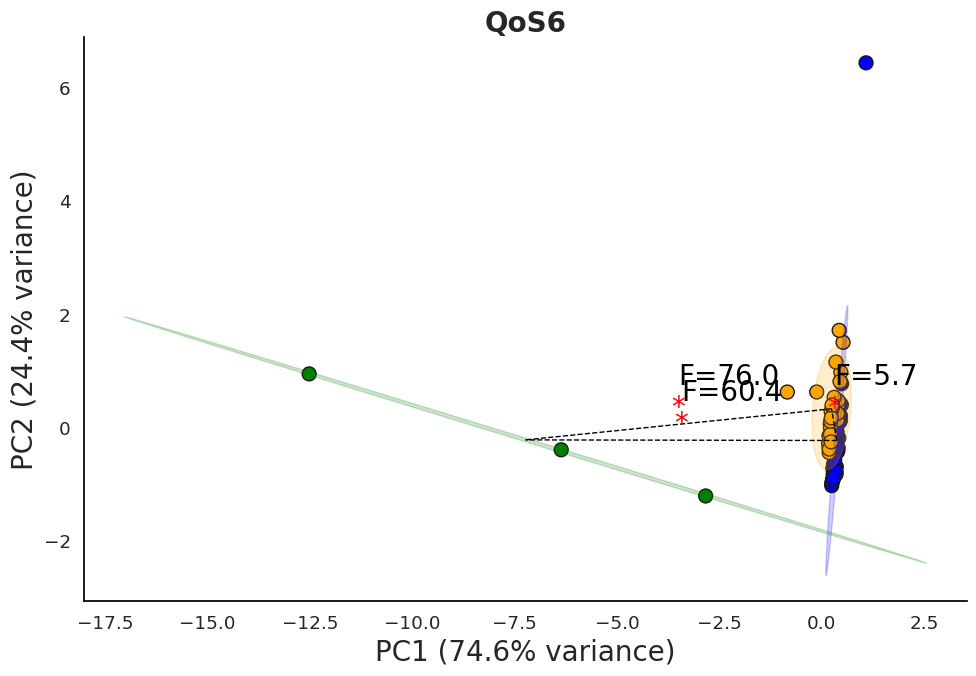

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.ordination import pcoa
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd

# --- PCoA ---
ordination = pcoa(dm)

# --- DataFrame for plotting ---
df_plot = pd.DataFrame({
    'PC1': ordination.samples['PC1'],
    'PC2': ordination.samples['PC2'],
    'Model': grouping_aligned.values
}, index=dm.ids)

# --- Ellipse function ---
def draw_ellipse(x, y, ax, n_std=2.0, **kwargs):
    if len(x) < 2:
        return
    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

# --- Plot setup ---
sns.set(style="white", font_scale=1.2)  # white background, no grid
plt.figure(figsize=(10,7))



# --- Plot points with specified colors and markers ---
markers = {'BI-GRU':'o','LSTM':'o','ARIMA':'o'}  # ARIMA as square
sizes = {'BI-GRU':100, 'LSTM':100, 'ARIMA':100}  # ARIMA larger

for model in df_plot['Model'].unique():
    subset = df_plot[df_plot['Model'] == model]
    plt.scatter(
        subset['PC1'], subset['PC2'],
        s=sizes[model],
        c=[model_colors[model]]*len(subset), # Use the custom color palette
        edgecolor='k',
        marker=markers[model],
        label=model
    )

ax = plt.gca()

# --- Draw ellipses and centroids ---
centroids = {}
for model in df_plot['Model'].unique():
    subset = df_plot[df_plot['Model'] == model]
    draw_ellipse(subset['PC1'], subset['PC2'], ax, n_std=2, alpha=0.2, color=model_colors[model]) # Use custom color for ellipses
    centroids[model] = (subset['PC1'].mean(), subset['PC2'].mean())

# --- Pairwise PERMANOVA table (replace with your results) ---
# Assuming you have a DataFrame named df_pairwise from the pairwise PERMANOVA step
# If not, you might need to run that step first or manually create this DataFrame
try:
    pairwise_results = df_pairwise.copy()
except NameError:
    print("Warning: df_pairwise not found. Using a placeholder DataFrame for pairwise results.")
    pairwise_results = pd.DataFrame({
        'Group1': ['BI-GRU', 'BI-GRU', 'LSTM'],
        'Group2': ['LSTM', 'ARIMA', 'ARIMA'],
        'pseudo-F': [11.851407, 118.360083, 103.402877],
        'p-adj': [0.003, 0.003, 0.003] # Placeholder p-adjusted values
    })


# --- Draw lines with significance and pseudo-F ---
for _, row in pairwise_results.iterrows():
    g1, g2 = row['Group1'], row['Group2']
    # Ensure both groups exist in centroids before plotting
    if g1 in centroids and g2 in centroids:
        x1, y1 = centroids[g1]
        x2, y2 = centroids[g2]
        ax.plot([x1, x2], [y1, y2], color='black', linestyle='--', lw=1)
        # Add significance asterisk
        # Check if p-adjusted value is significant (e.g., < 0.05)
        if row['p-adj'] < 0.05:
             ax.text((x1+x2)/2, (y1+y2)/2 + 0.05, "*", color='red', fontsize=20, ha='center', va='bottom')
        # Add pseudo-F value above the line
        ax.text((x1+x2)/2, (y1+y2)/2 + 0.6, f"F={row['pseudo-F']:.1f}", color='black', fontsize=20, ha='left', va='bottom')


# --- Show axes with black lines, remove grid ---
ax.grid(False)  # remove grid
ax.set_xlabel(f"PC1 ({ordination.proportion_explained['PC1']*100:.1f}% variance)", fontsize=20)
ax.set_ylabel(f"PC2 ({ordination.proportion_explained['PC2']*100:.1f}% variance)", fontsize=20)

# Set X and Y axis spines to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.title(file_var +' Metrics by Model\nwith 95% Confidence Ellipses & Pairwise Significance')
#plt.legend(title='Model', loc='best')
plt.title(file_var, fontsize=20,loc='center',pad=-0,fontweight='bold')
plt.tight_layout()

# Save PDF **before** showing
plt.savefig(file_var + "_PCoA.pdf", format='pdf', dpi=300)


plt.show()

In [ ]:
# Proportion of variance explained by each principal coordinate
explained = ordination.proportion_explained

print("Variance explained by each axis:")
print(explained)

# Total variance explained by the first two axes
pc1 = explained['PC1'] * 100
pc2 = explained['PC2'] * 100
total = pc1 + pc2

print(f"\nPC1 explains {pc1:.2f}% of the variance")
print(f"PC2 explains {pc2:.2f}% of the variance")
print(f"Together PC1 + PC2 explain {total:.2f}% of the variance")

Variance explained by each axis:
PC1     0.745779
PC2     0.243975
PC3     0.010144
PC4     0.000102
PC5     0.000000
          ...   
PC68    0.000000
PC69    0.000000
PC70    0.000000
PC71    0.000000
PC72    0.000000
Length: 72, dtype: float64

PC1 explains 74.58% of the variance
PC2 explains 24.40% of the variance
Together PC1 + PC2 explain 98.98% of the variance
